# ANLY 590 Assignment 2

## 1. Autoencoder

A convolutional autoencoder is a particular flavor of autoencoder where we
use convolutional layers instead of dense layers. We have previously applied
autoencoders to images using only Dense layers and the result worked fairly
well. However, the local spatial correlations of images imply that we should be
able to do better using convolutional layers instead of Dense layers.

Build and fit a convolutional autoencoder for the Fashion MNIST dataset.
The components of this network will be many of the same pieces we’ve used
with convolutional classification networks: Conv2D, MaxPooling, and so on.
The encoder part of the network should run the input image through a few
convolutional layers of your choice. The decoder part of the network will utilize
UpSampling2D to get the representation back to the original image size.

An example to guide your thinking can be found toward the bottom of this
post https://blog.keras.io/building-autoencoders-in-keras.html.

After training your network, visualize some examples of input images and
their decoded reconstruction.

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Reshape
from keras.models import Model
from keras.models import Sequential
from keras import backend as K
from keras import utils, optimizers
from keras.utils.np_utils import to_categorical
from keras.datasets import fashion_mnist
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import SGD, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import cv2
import pandas as pd
import requests
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [4]:
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 8s 141us/step - loss: 0.3529 - val_loss: 0.3134
Epoch 2/30
60000/60000 [==============================] - 7s 115us/step - loss: 0.3060 - val_loss: 0.3046
Epoch 3/30
60000/60000 [==============================] - 7s 114us/step - loss: 0.2977 - val_loss: 0.2994
Epoch 4/30
60000/60000 [==============================] - 7s 113us/step - loss: 0.2928 - val_loss: 0.2964
Epoch 5/30
60000/60000 [==============================] - 7s 114us/step - loss: 0.2898 - val_loss: 0.2907
Epoch 6/30
60000/60000 [==============================] - 7s 114us/step - loss: 0.2877 - val_loss: 0.2924
Epoch 7/30
60000/60000 [==============================] - 7s 114us/step - loss: 0.2857 - val_loss: 0.2861
Epoch 8/30
60000/60000 [==============================] - 7s 114us/step - loss: 0.2842 - val_loss: 0.2853
Epoch 9/30
60000/60000 [==============================] - 7s 113us/step - loss: 0.2828 - val_loss: 0.2

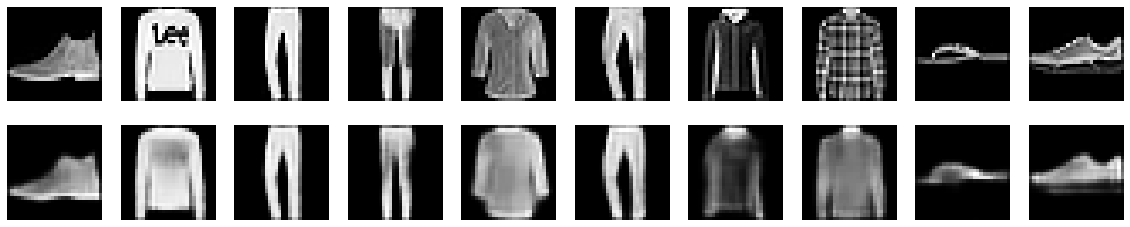

In [5]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2. Image Classification

We’ll continue to use the Fashion MNIST dataset and build a deep convolutional
network for classification.

## 2.1. Deep CNN

Build a deep CNN to classify the images. Provide a brief description of the
architectural choices you’ve made: kernel sizes, strides, padding, network depth.
Train your network end-to-end. Report on your model’s performance on training
set and test set.

(60000, 28, 28)


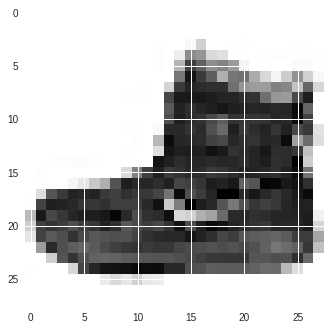

In [11]:
 # Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Shape check and plotting
print(X_train.shape)
plt.imshow(X_train[0])

In [12]:
model = Sequential([
    Conv2D(32, (5, 5), padding="same", input_shape=[28, 28, 1]),
    MaxPooling2D((2,2)),
    Conv2D(64, (5, 5), padding="same"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

X_train = X_train.reshape([-1, 28, 28, 1])
X_test = X_test.reshape([-1, 28, 28, 1])
X_train = X_train/255
X_test = X_test/255

y_train = utils.np_utils.to_categorical(y_train)
y_test = utils.np_utils.to_categorical(y_train)

model.compile(optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=64, epochs=30, verbose=2)

Epoch 1/30
 - 10s - loss: 0.8158 - acc: 0.7180
Epoch 2/30
 - 10s - loss: 0.5289 - acc: 0.8133
Epoch 3/30
 - 10s - loss: 0.4627 - acc: 0.8388
Epoch 4/30
 - 10s - loss: 0.4245 - acc: 0.8521
Epoch 5/30
 - 10s - loss: 0.3980 - acc: 0.8606
Epoch 6/30
 - 10s - loss: 0.3774 - acc: 0.8678
Epoch 7/30
 - 10s - loss: 0.3641 - acc: 0.8720
Epoch 8/30
 - 10s - loss: 0.3482 - acc: 0.8764
Epoch 9/30
 - 10s - loss: 0.3355 - acc: 0.8810
Epoch 10/30
 - 10s - loss: 0.3251 - acc: 0.8845
Epoch 11/30
 - 10s - loss: 0.3160 - acc: 0.8882
Epoch 12/30
 - 10s - loss: 0.3046 - acc: 0.8911
Epoch 13/30
 - 10s - loss: 0.2986 - acc: 0.8928
Epoch 14/30
 - 10s - loss: 0.2873 - acc: 0.8977
Epoch 15/30
 - 10s - loss: 0.2831 - acc: 0.8983
Epoch 16/30
 - 10s - loss: 0.2740 - acc: 0.9016
Epoch 17/30
 - 10s - loss: 0.2700 - acc: 0.9038
Epoch 18/30
 - 10s - loss: 0.2641 - acc: 0.9051
Epoch 19/30
 - 10s - loss: 0.2606 - acc: 0.9068
Epoch 20/30
 - 10s - loss: 0.2525 - acc: 0.9086
Epoch 21/30
 - 10s - loss: 0.2480 - acc: 0.9102
E

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               401536    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

From the results above, we can see that, by the 30th Epoch, the accuracy is 0.9265 and the loss is 0.2013, which are quite satisfying. They show that this model has a good performance on Fashion Mnist dataset. 

## 2.2.  Transfer Learning

Repeat the same task, but this time utilize a pre-trained network for the majority
of your model. You should only train the final Dense layer, all other weightsshould be fixed. You can use whichever pre-trained backbone you like (ResNet,
VGG, etc). Report on your model’s performance on training set and test set.

In [48]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = [cv2.cvtColor(cv2.resize(i,(32,32)), cv2.COLOR_GRAY2BGR) for i in X_train]
X_train = np.concatenate([arr[np.newaxis] for arr in X_train]).astype('float32')
 
X_test  = [cv2.cvtColor(cv2.resize(i,(32,32)), cv2.COLOR_GRAY2BGR) for i in X_test ]
X_test  = np.concatenate([arr[np.newaxis] for arr in X_test] ).astype('float32')

print(X_train.shape)

(60000, 32, 32, 3)


In [49]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(32,32,3))
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(10, activation="sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_26 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 14,848,586
Non-trainable params: 0
_________________________________________________________________


In [50]:
def build_dim(y):
    y_m = np.zeros(10)
    y_m[y] = 1
    return y_m
    
y_train = np.array([build_dim(y_train[i]) for i in range(len(y_train))])
y_test  = np.array([build_dim(y_test [i]) for i in range(len(y_test ))])

conv_base.trainable = False
model.compile(loss="binary_crossentropy", optimizer=RMSprop(1e-4),metrics=["acc"])
model.fit(X_train, y_train, epochs=10, batch_size = 64)


Epoch 1/10
60000/60000 [==============================] - 26s 437us/step - loss: 0.2716 - acc: 0.9383
Epoch 2/10
60000/60000 [==============================] - 25s 419us/step - loss: 0.1234 - acc: 0.9604
Epoch 3/10
60000/60000 [==============================] - 25s 419us/step - loss: 0.1018 - acc: 0.9652
Epoch 4/10
60000/60000 [==============================] - 25s 419us/step - loss: 0.0906 - acc: 0.9678
Epoch 5/10
60000/60000 [==============================] - 25s 418us/step - loss: 0.0833 - acc: 0.9700
Epoch 6/10
60000/60000 [==============================] - 25s 418us/step - loss: 0.0779 - acc: 0.9715
Epoch 7/10
60000/60000 [==============================] - 25s 418us/step - loss: 0.0740 - acc: 0.9728
Epoch 8/10
60000/60000 [==============================] - 25s 416us/step - loss: 0.0705 - acc: 0.9738
Epoch 9/10
60000/60000 [==============================] - 25s 417us/step - loss: 0.0677 - acc: 0.9747
Epoch 10/10
60000/60000 [==============================] - 25s 417us/step - loss: 

In [51]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 6s 611us/step


[0.09201093460321426, 0.9675000000953674]

From the results above, we can see that the accuracy for both train and test sets are over 0.96. The result shows that the pretrained model has good performance on Fashion Mnist dataset. 

## 3. Text Classification

Build and train a Recurrent Neural Network to solve this text classification task.
You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).

In [0]:
malicious = requests.get('https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt').text.split('\n')
benign = requests.get('https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt').text.split('\n')
text = malicious + benign

label = [0 for _ in range(len(benign))]+[1 for _ in range(len(malicious))]

text_train,text_test,label_train,label_test = train_test_split(text,label,test_size=0.1)

In [0]:
MAX_NUM_WORDS = 500 
MAX_SEQUENCE_LENGTH = 50 

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(text)
train_sequences = tokenizer.texts_to_sequences(text_train) 
test_sequences = tokenizer.texts_to_sequences(text_test)

In [27]:
print('Sample sequence: ' + ' '.join(str(e) for e in train_sequences[19]))

Sample sequence: 34 3 2 1


In [0]:
text_train_2 = pad_sequences(train_sequences,maxlen=MAX_NUM_WORDS)
text_test_2 = pad_sequences(test_sequences,maxlen=MAX_NUM_WORDS)
